In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from dataclasses import dataclass
import pyclothoids
from fontTools.ttLib import TTFont

plt.rcParams['figure.dpi'] = 200

In [2]:
@dataclass
class Curve:
    x: float
    y: float
    k0: float
    k1: float

In [3]:
# Based on `kurbo` library
def spiro(k0, k1):
    t1_1 = k0
    t1_2 = 0.5 * k1
    t2_2 = t1_1 * t1_1
    t2_3 = 2.0 * (t1_1 * t1_2)
    t2_4 = t1_2 * t1_2
    t3_4 = t2_2 * t1_2 + t2_3 * t1_1
    t3_6 = t2_4 * t1_2
    t4_4 = t2_2 * t2_2
    t4_5 = 2.0 * (t2_2 * t2_3)
    t4_6 = 2.0 * (t2_2 * t2_4) + t2_3 * t2_3
    t4_7 = 2.0 * (t2_3 * t2_4)
    t4_8 = t2_4 * t2_4
    t5_6 = t4_4 * t1_2 + t4_5 * t1_1
    t5_8 = t4_6 * t1_2 + t4_7 * t1_1
    t5_10 = t4_8 * t1_2
    t6_6 = t4_4 * t2_2
    t6_7 = t4_4 * t2_3 + t4_5 * t2_2
    t6_8 = t4_4 * t2_4 + t4_5 * t2_3 + t4_6 * t2_2
    t6_9 = t4_5 * t2_4 + t4_6 * t2_3 + t4_7 * t2_2
    t6_10 = t4_6 * t2_4 + t4_7 * t2_3 + t4_8 * t2_2
    t7_8 = t6_6 * t1_2 + t6_7 * t1_1
    t7_10 = t6_8 * t1_2 + t6_9 * t1_1
    t8_8 = t6_6 * t2_2
    t8_9 = t6_6 * t2_3 + t6_7 * t2_2
    t8_10 = t6_6 * t2_4 + t6_7 * t2_3 + t6_8 * t2_2
    t9_10 = t8_8 * t1_2 + t8_9 * t1_1
    t10_10 = t8_8 * t2_2
    
    u = 1.
    u -= (1. / 24.) * t2_2 + (1. / 160.) * t2_4
    u += (1. / 1920.) * t4_4 + (1. / 10752.) * t4_6 + (1. / 55296.) * t4_8
    u -= (1. / 322560.) * t6_6 + (1. / 1658880.) * t6_8 + (1. / 8110080.) * t6_10
    u += (1. / 92897280.) * t8_8 + (1. / 454164480.) * t8_10
    u -= 2.4464949595157930e-11 * t10_10
    
    v = (1. / 12.) * t1_2
    v -= (1. / 480.) * t3_4 + (1. / 2688.) * t3_6
    v += (1. / 53760.) * t5_6 + (1. / 276480.) * t5_8 + (1. / 1351680.) * t5_10
    v -= (1. / 11612160.) * t7_8 + (1. / 56770560.) * t7_10
    v += 2.4464949595157932e-10 * t9_10
    
    return u, v

def spiro_n(k0, k1):
    accuracy = 1.0e-12

    c1 = np.abs(k1);
    c0 = np.abs(k0) + 0.5 * c1
    est_err_raw = 0.006 * c0 * c0 + 0.029 * c1
    if est_err_raw**6 < accuracy:
        return spiro(k0, k1)
    else:
        n = int(np.ceil(est_err_raw / accuracy**(1.0 / 6.0)))

        s1s0 = 1.0 / n

        px = 0.0
        py = 0.0

        # s0 = -0.5, s1 = -0.5 + s1s0, s = (s0 + s1) * 0.5
        s = -0.5 + 0.5 * s1s0

        for i in range(n):
            (u, v) = spiro(s1s0 * (k0 + k1 * s), s1s0**2 * k1)

            theta = k0 * s + 0.5 * k1 * s**2
            tc, ts = np.cos(theta), np.sin(theta)

            px += tc * u - ts * v
            py += tc * v + ts * u

            s += s1s0
        
        return (px * s1s0, py * s1s0)

def eval_euler(s0, s1, u):
    th = u[0]
    k0 = u[1]
    k1 = u[2]

    s1s0 = s1 - s0
    s = (s0 + s1) * 0.5
    u, v = spiro_n(s1s0 * (k0 + k1 * s), s1s0**2 * k1)
    theta = k0 * s + 0.5 * k1 * s**2 + th
    tc, ts = np.cos(theta), np.sin(theta)
    x = s1s0 * (tc * u - ts * v)
    y = s1s0 * (tc * v + ts * u)

    return x, y
    
def fit_euler(th0, th1):
    k1_old = 0
    e_old = th1 - th0
    k0 = th0 + th1
    k1 = 6 * (1 - ((.5 / np.pi) * k0) ** 3) * e_old
    for i in range(10):
        x, y = spiro(k0, k1)
        theta = np.arctan2(y, x)
        e = (th1 - th0) + 2 * theta - .25 * k1
        if abs(e) < 1e-9:
            chord = np.hypot(x, y)
            return k0, k1, theta, chord
        k1_old, e_old, k1 = k1, e, k1 + (k1_old - k1) * e / (e - e_old)

0.5 2.0
0.6000000000000001 2.2
0.7000000000000001 2.4000000000000004
0.8 2.6
0.9 2.8


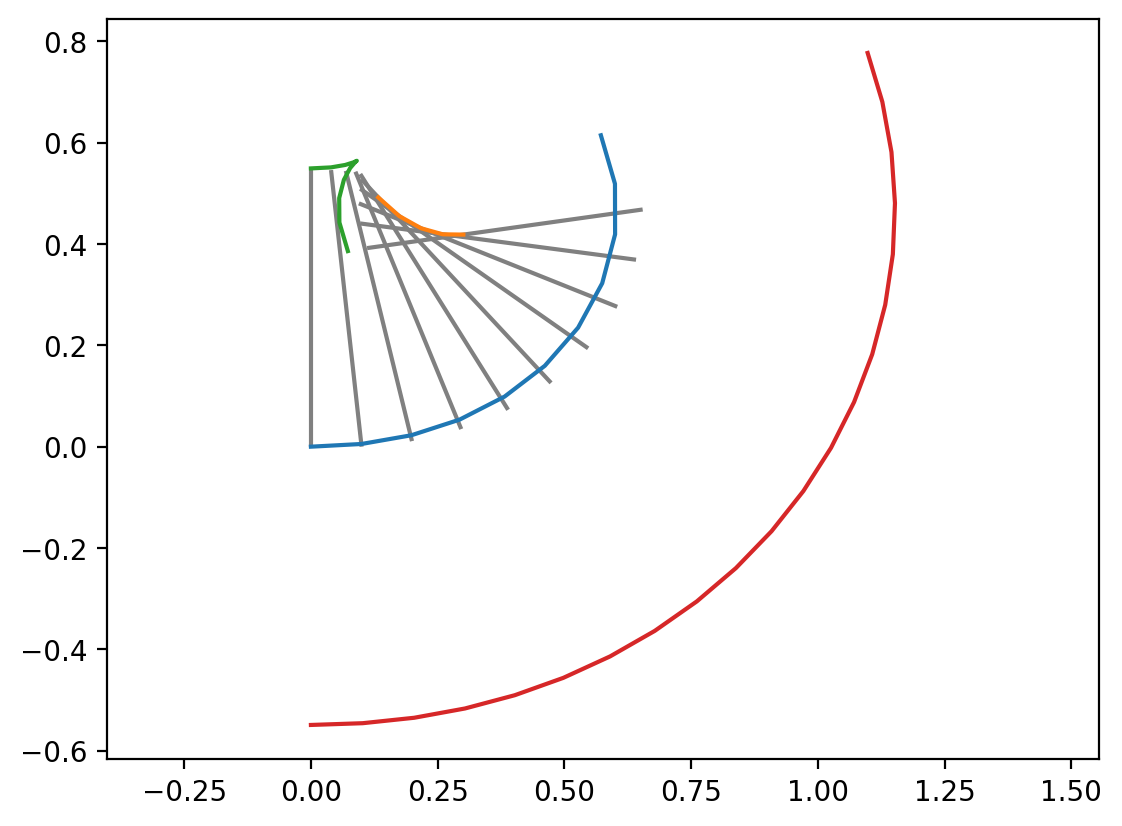

In [18]:
ds = 0.1
s = 0.0
L = 1.0

n = int(L / ds)

def spiral(t0, t1, k0, k1, theta = 0.0, offset=0.0):
    x = []
    y = []

    xn = 0.0
    yn = 0.0

    t = t0
    while t <= t1:
        curvature = k0 + k1 * t
        phi = k1 * t**2 / 2.0 + k0 * t + theta

        x.append(xn - offset * np.sin(phi))
        y.append(yn + offset * np.cos(phi))

        darc = ds

        cusp = np.abs(1.0 - offset * curvature)
        darc = min(1.0 / max(cusp, 0.0001), 1.0) * ds

        xk, yk = eval_euler(t, t+darc, [theta, k0, k1])
        
        xn += xk # darc * np.cos(phi)
        yn += yk # darc * np.sin(phi)

        t += darc

    return [x, y]

def spiral_evolute(k0, k1, offset=0.0):
    x = []
    y = []

    xn = 0.0
    yn = 0.0

    for i in range(n):
        t = (i * ds)
    
        phi = k1 * t**2 / 2.0 + k0 * t

        curvature = k0 + k1 * t
        p = 0.0

        if curvature != 0.0 and 1.0 < offset * curvature:
            print(t, curvature)
            p = 1.0 / curvature
    
            x.append(xn - p * np.sin(phi))
            y.append(yn + p * np.cos(phi))
        
        xn += ds * np.cos(phi)
        yn += ds * np.sin(phi)

    return [x, y]

def spiral_offset_lines(k0, k1, offset):
    xn = 0.0
    yn = 0.0

    lines = np.empty(n, dtype=object)

    for i in range(n):
        t = (i * ds)
        phi = k1 * t**2 / 2.0 + k0 * t

        ox = -offset * np.sin(phi)
        oy = offset * np.cos(phi)
        x0 = xn 
        y0 = yn

        x1 = x0 + ox
        y1 = y0 + oy;

        lines[i] = [(x0, y0), (x1, y1)]
        
        xn += ds * np.cos(phi)
        yn += ds * np.sin(phi)

    return LineCollection(lines, linestyle = "solid", colors="gray")

def curve_length(x, y):
    length = 0.0
    for i in range(1, len(x)):
        dx = x[i] - x[i-1]
        dy = y[i] - y[i-1]
        darc = np.sqrt(dx * dx + dy * dy)

        length += darc
    return length

k0 = 1.0
k1 = 2.0
phi0 = 0.0

dpi = 1.0
scale = dpi * 182.15316943682936
offset = 100.0 * dpi / 182.15316943682936

[x0, y0] = spiral(0.0, L, k0, k1, offset = 0.0)
[x1, y1] = spiral(0.0, L, k0, k1, offset = offset)
[x2, y2] = spiral(0.0, L, k0, k1, offset = -offset)
[xe0, ye0] = spiral_evolute(k0, k1, offset = offset)
normals0 = spiral_offset_lines(k0, k1, offset = offset)
normals1 = spiral_offset_lines(k0, k1, offset = -offset)

#print(curve_length(x0, y0, 0.0))
# print(curve_length(x1, y1, 0.4))

fig, ax = plt.subplots()
ax.add_collection(normals0)
#ax.add_collection(normals1)
ax.plot(x0, y0)
ax.plot(xe0, ye0)
ax.plot(x1, y1)
ax.plot(x2, y2)
ax.axis('equal')
plt.show()

1.5707963267948966 0.0
0.9899898220018533


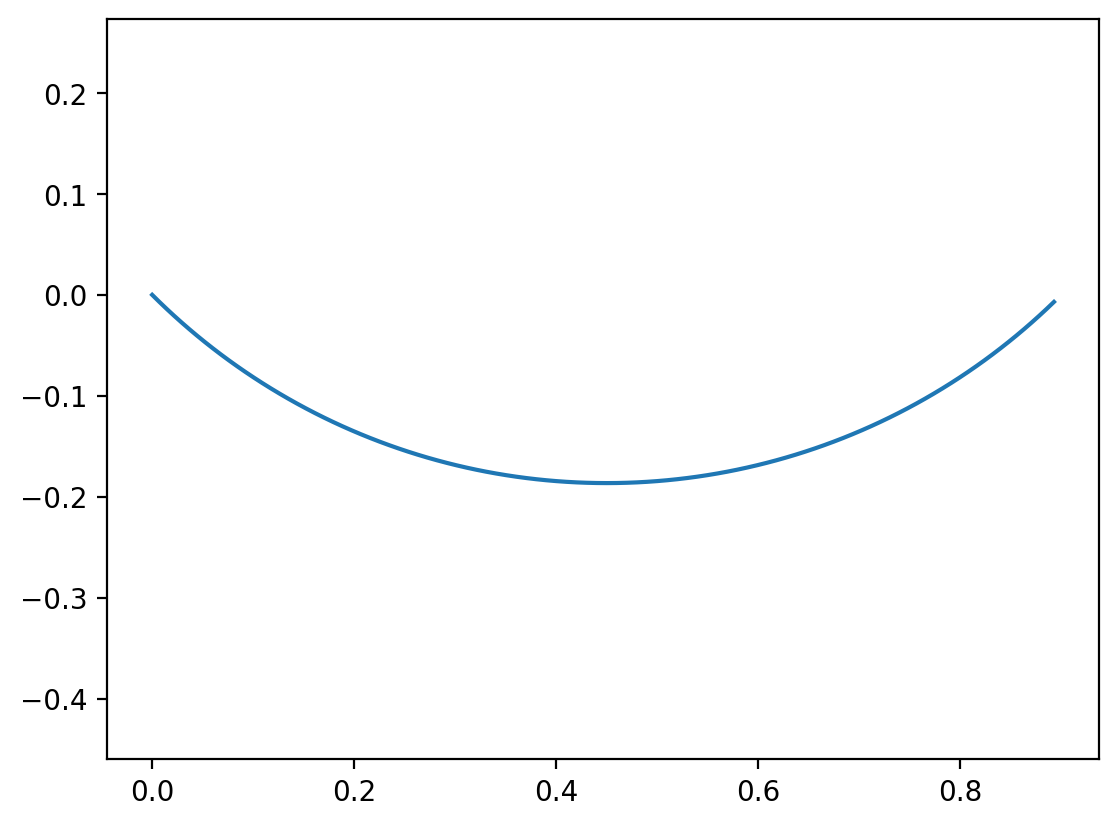

In [5]:
k0, k1, theta, chord = fit_euler(np.pi /4.0, np.pi /4.0)
print(k0, k1)

[x0, y0] = spiral(t0=-0.5, t1=0.5, k0=k0, k1=k1, offset = 0.0)
print(curve_length(x0, y0))

fig, ax = plt.subplots()
ax.plot(x0, y0)
ax.axis('equal')
plt.show()

In [6]:
@dataclass
class ParamG1:
    x: float
    y: float
    phi: float

@dataclass
class ParamG2:
    x: float
    y: float
    phi: float
    k: float

def fresnel_cs(a, b, c, n):
    fc = []
    fs = []

    if np.abs(a) < 0.01:
        nkk = n + 12 + 2

        # evalXYazero
        x0 = []
        y0 = []

        sb = np.sin(b)
        cb = np.cos(b)
        b2 = b**2

        if np.abs(b) < 1.0e-3:
            x0.append(1.0-(b2/6.0)*(1.0-(b2/20.0)*(1.0-(b2/42.0))))
            y0.append((b/2)*(1-(b2/12)*(1-(b2/30))))
        else:
            x0.append(sb/b)
            y0.append((1-cb)/b)
        
        m = np.floor(2*b)
        if m >= n:
            m = n - 1
        if m < 1:
            m = 1
        for k in range(1, m):
            x0.append((sb-k*y0[k-1])/b)
            y0.append((k*x0[k-1]-cb)/b)


def fit_g1(param0: ParamG1, param1: ParamG1):
    dx = param1.x - param0.x
    dy = param1.y - param0.y
    d = np.sqrt(dx**2 + dy**2)
    phi = np.arctan2(dy, dx)
    phi0 = param0.phi - phi
    phi1 = param1.phi - phi

    print(phi0, phi1)

    dphi = phi1 - phi0
    x = phi0 / np.pi
    y = phi1 / np.pi
    xy = x * y
    y *= y
    x *= x
    a = (phi0+phi1) * (2.989696028701907 + xy * (0.716228953608281 + xy * -0.458969738821509) + (-0.502821153340377 + xy * 0.261062141752652) * (x + y) - 0.045854475238709 * (x*x+y*y)) 

    # newton
    g = 0

def fit_g2(param0: ParamG2, param1: ParamG2):
    dx = param1.x - param0.x
    dy = param1.y - param0.y
    d = np.sqrt(dx**2 + dy**2)
    phi = np.arctan2(dy, dx)
    lmda = d / 2.0
    


p0 = ParamG1(-1.0, 0.0, np.pi / 3.0)
p1 = ParamG1(1.0, 0.0, -np.pi / 2.0)

fit_g1(p0, p1)

1.0471975511965976 -1.5707963267948966


(0.0, 1.0, 0.0, -1.0000000000000002, 2.873106197358048e-16, 1.5707963267948966)
(0.0, 1.0, 0.0, 0.0, -2.6393777662199636, 0.5235692063579954)
(0.5167586549735523, 0.9374523777537165, -0.36175933744872146, -1.3818969223387254, -1.1474518539855829e-15, 0.613126520655042)
(0.9374523777537166, 0.5167586549735522, -1.209036989346175, -1.3818969223387265, 2.6393777662199662, 0.5235692063579954)
(-1.0, 1.0, 0.0, 0.0, -0.6598444415549909, 1.0471384127159908)
(0.03351730994710456, 0.874904755507433, -0.36175933744872146, -0.6909484611693627, -2.868629634963957e-16, 1.226253041310084)
(0.8749047555074332, 0.033517309947104446, -1.209036989346175, -0.6909484611693633, 0.6598444415549916, 1.0471384127159908)


(-1.1, 1.1000000000000003, -1.0999999999999999, 1.1)

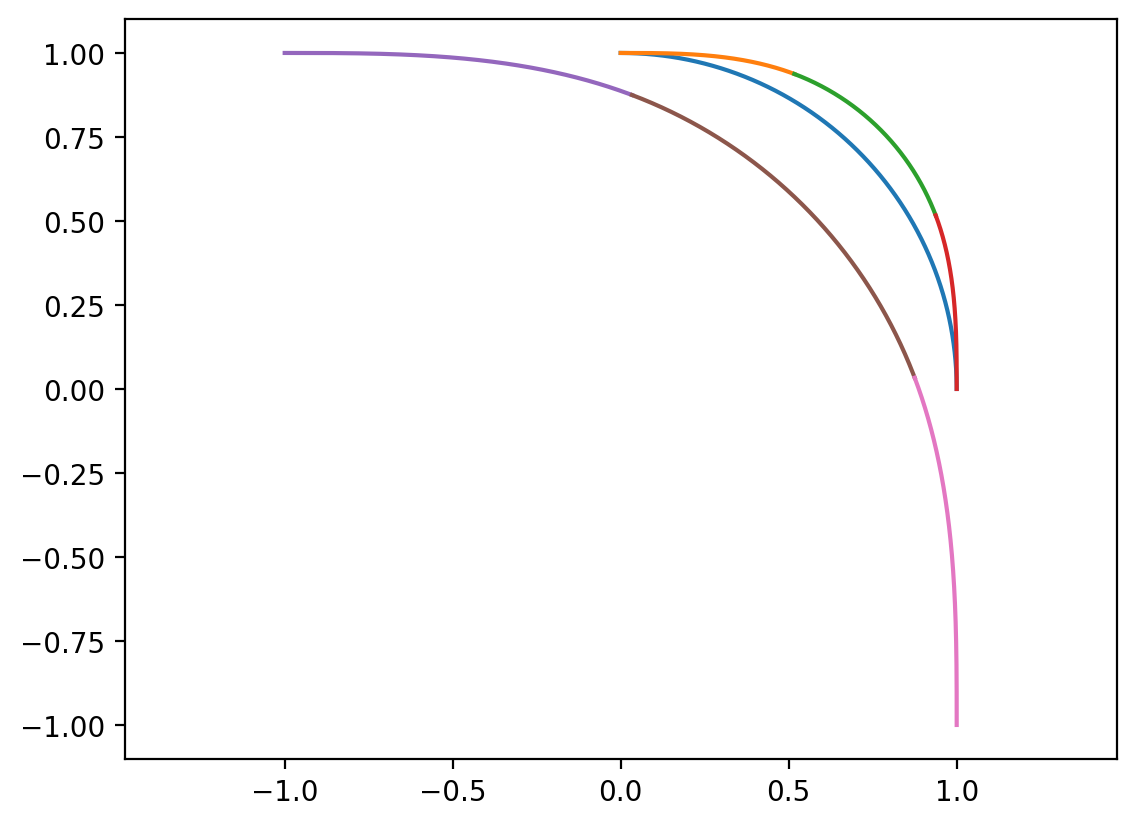

In [7]:
from pyclothoids import Clothoid, SolveG2

clothoid0 = Clothoid.G1Hermite(0, 1, 0.0, 1, 0, -np.pi / 2)
clothoid_list = SolveG2(0, 1, 0.0, 0.0, 1, 0, -np.pi / 2, 0.0)
clothoid_list2 = SolveG2(-1, 1, 0.0, 0.0, 1, -1, -np.pi / 2, 0.0)

fig, ax = plt.subplots()

ax.plot(*clothoid0.SampleXY(500))
print(clothoid0.Parameters)

# x, y, phi, k0, k1, L
for i in clothoid_list:
    print(i.Parameters)
    ax.plot( *i.SampleXY(500) )

for i in clothoid_list2:
    print(i.Parameters)
    ax.plot( *i.SampleXY(500) )

ax.axis('equal')



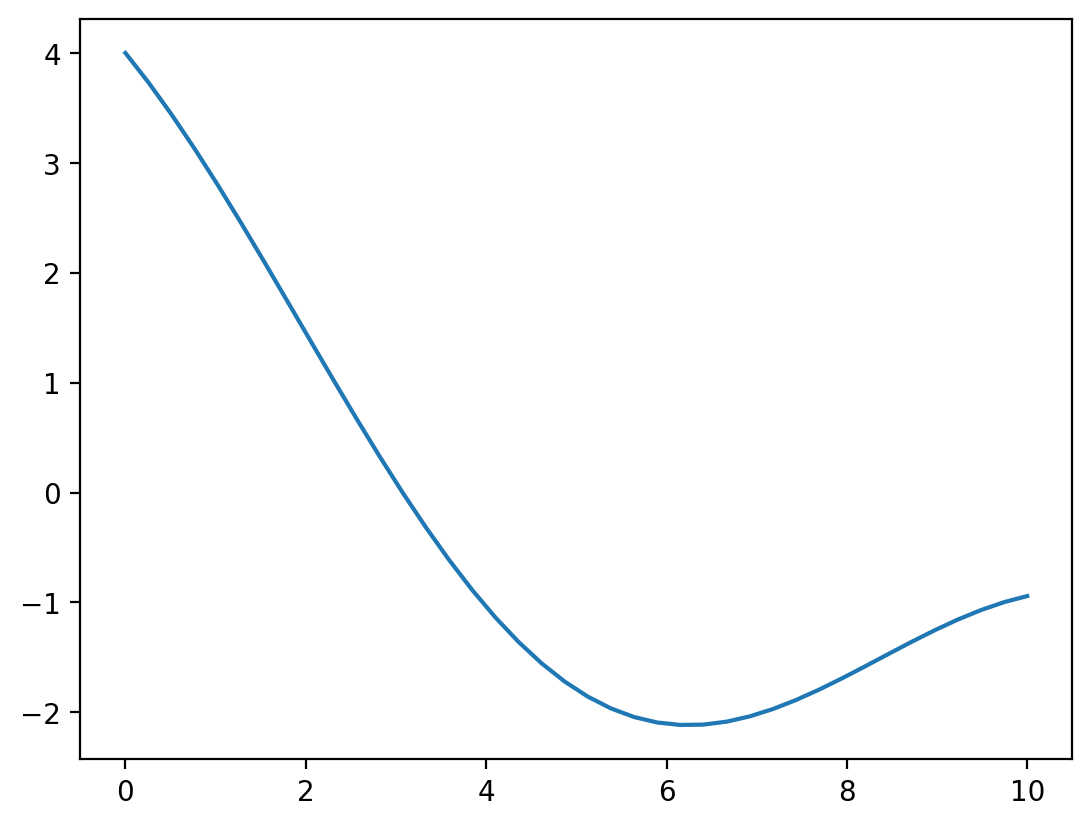

In [8]:
x = np.linspace(0.0, 10.0, 40)
d = 4.0
tetha = 0.7

y = np.array([d - v * eval_euler(0.0, 1.0, [0.0, 0.0, v])[0] - v * eval_euler(0.0, 1.0, [0.0, 0.0, v])[1] * np.tan(np.pi/2.0 - tetha) for v in x])
plt.plot(x, y)

0.9899966749116341


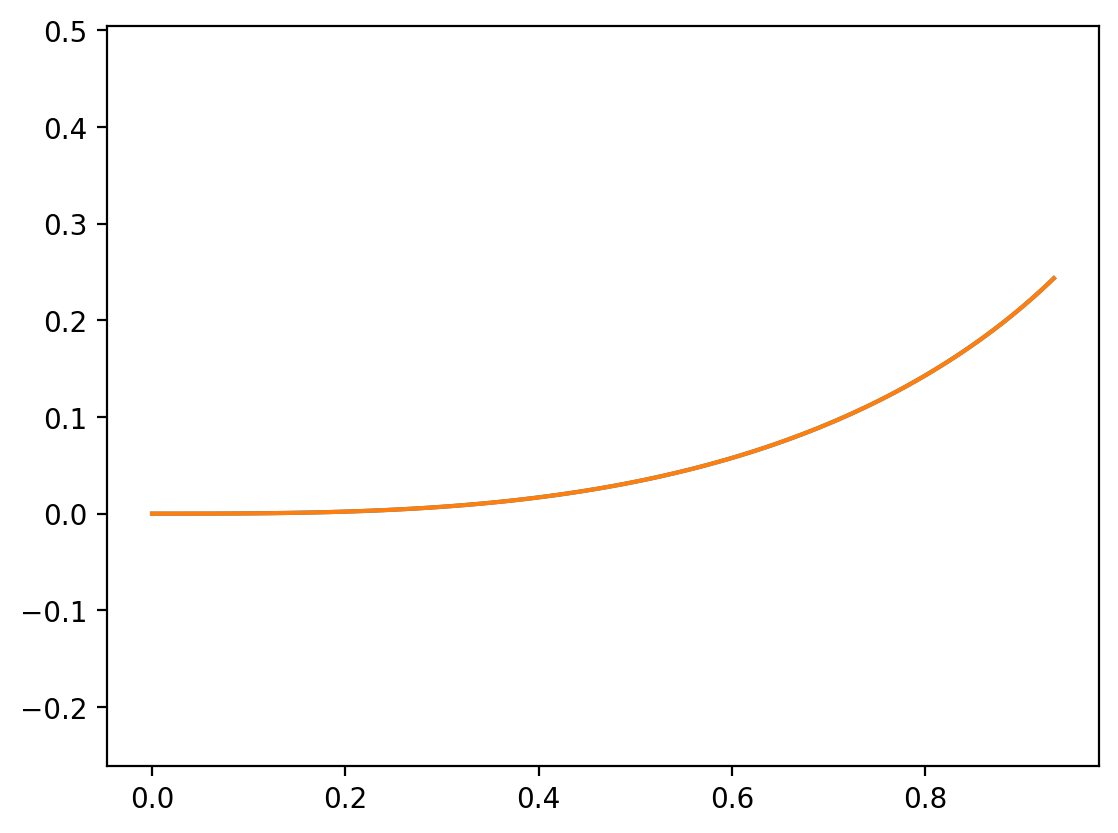

In [9]:
a = 1.0
k2 = np.pi / 2.0
[x0, y0] = spiral(0.0, a, 0.0, k2)
print(curve_length(x0, y0))
[x1, y1] = spiral(0.0, 1.0, 0.0, a**2 * k2)

plt.plot(x0, y0)
plt.axis('equal')
plt.plot(a * np.array(x1), a * np.array(y1))

In [10]:
from fontTools.pens.svgPathPen import SVGPathPen

font = TTFont("assets/segoeui.ttf")
glyphs = font.getGlyphSet()
svgpen = SVGPathPen(glyphs)
glyph = glyphs['kappa']
glyph.draw(svgpen)
path = svgpen.getCommands()
print(path)

M1043 0H840L470 500L329 348V0H166V1024H329V526L604 838Q721 971 777.5 1004.5Q834 1038 880 1038Q952 1038 986 1031V886Q956 894 906 894Q840 894 696 738L581 613Z


0.6038873786280614
cusp:  0.327968951985588
0.33 1.6600000000000001
0.34 1.6800000000000002
0.35000000000000003 1.7000000000000002
0.36 1.72
0.37 1.74
0.38 1.76
0.39 1.78
0.4 1.8
0.41000000000000003 1.82
0.42 1.8399999999999999
0.43 1.8599999999999999
0.44 1.88
0.45 1.9
0.46 1.92
0.47000000000000003 1.94
0.48 1.96
0.49 1.98
0.5 2.0
0.51 2.02
0.52 2.04
0.53 2.06
0.54 2.08
0.55 2.1
0.56 2.12
0.5700000000000001 2.14
0.58 2.16
0.59 2.1799999999999997
0.6 2.2
0.61 2.2199999999999998
0.62 2.24
0.63 2.26
0.64 2.2800000000000002
0.65 2.3
0.66 2.3200000000000003
0.67 2.34
0.68 2.3600000000000003
0.6900000000000001 2.38
0.7000000000000001 2.4000000000000004
0.71 2.42
0.72 2.44
0.73 2.46
0.74 2.48
0.75 2.5
0.76 2.52
0.77 2.54
0.78 2.56
0.79 2.58
0.8 2.6
0.81 2.62
0.8200000000000001 2.64
0.8300000000000001 2.66
0.84 2.6799999999999997
0.85 2.7
0.86 2.7199999999999998
0.87 2.74
0.88 2.76
0.89 2.7800000000000002
0.9 2.8
0.91 2.8200000000000003
0.92 2.84
0.93 2.8600000000000003
0.9400000000000001 2.8

(-6.917766019528381, 114.08137134755785, -6.982995644750638, 146.6429085397634)

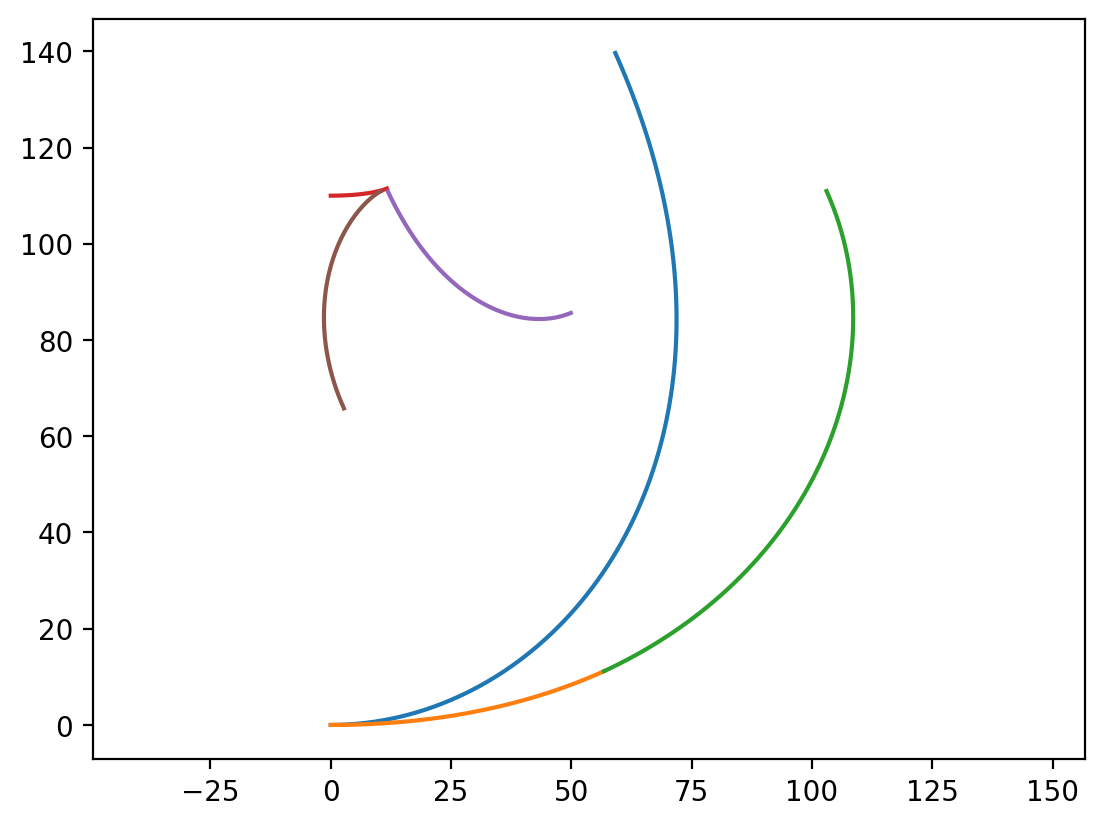

In [17]:
p0 = np.array([0, 0])
# p1 = np.array([0, 100])
# p2 = np.array([50, 150])
# p3 = np.array([100, 100])

# d10 = p1 - p0
# d32 = p3 - p2
# d30 = p3 - p0

# def cross(a, b):
#     return a[0]*b[1] - a[1]*b[0]

# def dot(a, b):
#     return a[0]*b[0] + a[1]*b[1]

# th0 = np.arctan2(cross(d30, d10), dot(d30, d10))
# th1 = np.arctan2(cross(d32, d30), dot(d32, d30))
# th = np.arctan2(d30[1], d30[0])


# print(th0, th1)

# k1, k2, k0, chord = fit_euler(-th0, -th1)
# scale = np.sqrt(dot(d30, d30)) / chord
# print(scale)

# k0 = th - k0
# u0 = k0 - 0.5 * k1 + 0.125 * k2
# u1 = (k1 - k2 * 0.5)
# u2 = k2

scale = 1.0 * 182.15316943682936

u0 = 0.0
u1 = 1.0
u2 = 2.0

offset = 110.0 * 1.0 / scale
print(offset)
cusp = (1. - u1 * offset) / (u2 * offset)
print('cusp: ', cusp)

[x0, y0] = spiral(t0=0.0, t1=cusp, k0=u1, k1=u2, theta=u0, offset = 0.0)
[x1, y1] = spiral(t0=cusp, t1=1.0, k0=u1, k1=u2, theta=u0, offset = 0.0)
[d1, e1] = spiral(t0=0.0, t1=cusp, k0=u1, k1=u2, theta=u0, offset = offset)
[d2, e2] = spiral(t0=cusp, t1=1.0, k0=u1, k1=u2, theta=u0, offset = offset)
[d3, e3] = spiral(t0=0.0, t1=1.0, k0=u1, k1=u2, theta=u0, offset = -offset)
[evx, evy] = spiral_evolute(k0=u1, k1=u2,offset = offset)
print(u0, u1, u2)
print("len: ", curve_length(x0, y0))

print(x0[-1] * scale)

plt.plot(np.array(x0) * scale + p0[0], np.array(y0) * scale + p0[1])
plt.plot(np.array(x1) * scale + x0[-1] * scale + p0[0], np.array(y1) * scale + y0[-1] * scale + p0[1])
plt.plot(np.array(d1) * scale + p0[0], np.array(e1) * scale + p0[1])
plt.plot(np.array(evx) * scale + p0[0], np.array(evy) * scale + p0[1])
# plt.plot(np.array(d3) * scale + p0[0], np.array(e3) * scale + p0[1])
plt.plot(np.array(d2) * scale + x0[-1] * scale + p0[0], np.array(e2) * scale + y0[-1] * scale + p0[1])
# plt.plot(p0[0], p0[1], marker="o")
# plt.plot(p1[0], p1[1], marker="o")
# plt.plot(p2[0], p2[1], marker="o")
# plt.plot(p3[0], p3[1], marker="o")
plt.axis('equal')

# clothoid0 = Clothoid.G1Hermite(p0[0], p0[1], np.arctan2(d10[1], d10[0]), p3[0], p3[1], np.arctan2(d32[1], d32[0]))
# print(clothoid0.Parameters)

# plt.plot(*clothoid0.SampleXY(500), 'r--')
